In [1]:
import os
import csv
import torch
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

from gpolnel.utils.datasets import load_boston
from torch.utils.data import TensorDataset, DataLoader

from gpolnel.problems.inductive_programming import SML
from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.inductive_programming import function_map
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm
from gpolnel.operators.initializers import grow, prm_grow, ERC
from gpolnel.operators.variators import swap_xo, prm_subtree_mtn
from gpolnel.operators.selectors import prm_tournament, roulette_wheel, rank_selection
from gpolnel.utils.inductive_programming import _execute_tree
seed=1
#_evaluate_individual_ffunction

In [2]:
##to do
#crossover
#random search
#exercises

In [3]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cpu'

In [4]:
X_train = torch.tensor(pd.read_csv('datamart/X_train.csv').values)
X_test = torch.tensor(pd.read_csv('datamart/X_test.csv').values)
y_train = torch.tensor(pd.read_csv('datamart/y_lactose_train.csv')['lactose_percent'].values)
y_test = torch.tensor(pd.read_csv('datamart/y_lactose_test.csv')['lactose_percent'].values)

In [5]:
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1
total_batches = 1
batch_size = X_train.shape[0]
print('Batch size: {}\nTotal batches: {}\n'.format(batch_size, total_batches))

print('Train:\t{}\nVal:\t{}\nTest:\t{}'.format(X_train.shape[0], X_test.shape[0], X_test.shape[0]))
print('Total:\t{}'.format(X_train.shape[0] + X_test.shape[0] + X_test.shape[0]))

# Creates training and validatation data sets
ds_train = TensorDataset(X_train, y_train)
ds_val = TensorDataset(X_test, y_test)

# Creates training and test data loaders
dl_train = DataLoader(ds_train, batch_size, shuffle)
dl_val = DataLoader(ds_val, batch_size, shuffle)

Batch size: 226
Total batches: 1

Train:	226
Val:	98
Test:	98
Total:	422


In [6]:
fset = [function_map['add'], function_map['sub'], function_map['mul'], function_map['div']]

sspace_sml = {
    'n_dims': X_train.shape[1],
    'function_set': fset, 'constant_set': ERC(-1., 1.),
    'p_constants': 0.1,
    'max_init_depth': 3,
    'max_depth': 3, 
    'n_batches': total_batches,
    'device': device
}


In [7]:
pi_sml = SML(
    sspace=sspace_sml,
    ffunction=Ffunctions('mse'),
    dl_train=dl_train, dl_test=dl_val,  # For the algorithm, the unseen is our validation!
    n_jobs=8
)


In [8]:
ps = 226
selection_pressure = .06
mutation_prob = .15
xo_prob = .9
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=grow,
    selector=prm_tournament(pressure=selection_pressure),  #prm_tournament(pressure=selection_pressure)
    crossover=swap_xo,
    mutator=prm_subtree_mtn(initializer=prm_grow(sspace_sml)),
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed
)

In [9]:
mheuristic._initialize()

TypeError: grow() got an unexpected keyword argument 'n_sols'

In [ ]:
print(mheuristic.pop)

0)	[sub, mul, div, 6, tensor(-0.9433), 0, 3] (fit: tensor(6.1211e+13))
1)	[add, add, 0, 6, sub, 8, 10] (fit: tensor(6.1211e+13))
2)	[sub, 6, sub, 5, 10] (fit: tensor(6.1211e+13))
3)	[sub, 7, 0] (fit: tensor(6.1211e+13))
4)	[div, 2, 11] (fit: tensor(6.1211e+13))
5)	[mul, 1, 6] (fit: tensor(6.1211e+13))
6)	[mul, div, 9, 2, add, 8, 5] (fit: tensor(6.1211e+13))
7)	[mul, 9, div, 8, 0] (fit: tensor(6.1211e+13))
8)	[div, div, 6, tensor(0.0802), 0] (fit: tensor(6.1211e+13))
9)	[sub, sub, mul, 10, tensor(-0.9666), mul, 9, 1, sub, 2, 4] (fit: tensor(6.1211e+13))
10)	[div, 1, mul, 3, 11] (fit: tensor(6.1211e+13))
11)	[sub, 0, add, 11, div, 3, 10] (fit: tensor(6.1211e+13))
12)	[add, 6, mul, 0, tensor(-0.8471)] (fit: tensor(6.1211e+13))
13)	[mul, div, 8, sub, 11, 5, sub, 7, div, 0, 6] (fit: tensor(6.1211e+13))
14)	[mul, 5, 3] (fit: tensor(6.1211e+13))
15)	[mul, div, 10, 8, add, add, 8, 5, 5] (fit: tensor(6.1211e+13))
16)	[add, div, 1, tensor(-0.8536), sub, 9, tensor(0.1005)] (fit: tensor(6.1211e+13

In [ ]:
print(mheuristic.pop.individuals[0].repr_)

[sub, mul, div, 6, tensor(-0.9433), 0, 3]


In [ ]:
mheuristic.pop.individuals[0].printTree()

sub( mul( div( x_6, -0.9433 ) x_0 ) x_3 )


In [ ]:
feature_names = pd.read_csv('datamart/X_train_clipped_scaled.csv').columns
mheuristic.pop.individuals[0].printTree(feature_names=feature_names)

sub( mul( div( milkings_day, -0.9433 ) lactation ) rumination_min_day )


In [ ]:
print(f'\nGP population: {mheuristic.pop.__class__} ({len(mheuristic.pop)} individuals)')

print(f'\nPoppulation fitness {mheuristic.pop.fit[:3]}...')
print(f'Poppulation valid {mheuristic.pop.valid[:3]}...\n')

for i in range(3):
    print(f'Individual {i}: {mheuristic.pop.individuals[i].repr_}, fitness {mheuristic.pop.individuals[i].fit}')

print(f'\nGP best individual {mheuristic.best_sol.printTree(out="string")}, fitness {mheuristic.best_sol.fit}\n\n')



GP population: <class 'gpolnel.utils.population.PopulationTree'> (226 individuals)

Poppulation fitness tensor([6.1211e+13, 6.1211e+13, 6.1211e+13])...
Poppulation valid [True, True, True]...

Individual 0: [sub, mul, div, 6, tensor(-0.9433), 0, 3], fitness 61211295088640.0
Individual 1: [add, add, 0, 6, sub, 8, 10], fitness 61211295088640.0
Individual 2: [sub, 6, sub, 5, 10], fitness 61211295088640.0

GP best individual div( x_1, x_7 ), fitness 61211295088640.0




In [ ]:
# Log settings
file_dir = './log/'
file_name = 'intro.log'
log_path = file_dir + file_name
if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

# Learning
n_iter = 3000

mheuristic.solve(
    n_iter,
    verbose=3, log=3, log_path=log_path,
    test_elite=True
)

-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 3        6.11525e+12      1020.73               0.104 | -1                             -1
1          | 3        6.11525e+12      444.297               0.203 | -1                             -1
2          | 1        8.79359e+11      21.4786               0.134 | -1                             -1
3          | 3        9.86264e+10      24.0249               0.128 | -1                             -1
4          | 3        8.34343e+10      24.4825               0.139 | 

Traceback (most recent call last):
  File "C:\Users\leond\AppData\Roaming\Python\Python311\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\leond\AppData\Local\Temp\ipykernel_36620\354524834.py", line 13, in <module>
    mheuristic.solve(
  File "c:\Users\leond\OneDrive\Desktop\NeuroEvolutionaryLearning\Project\gpolnel\algorithms\genetic_algorithm.py", line 296, in solve
    offs_pop = globals()[self.pop.__class__.__name__](offs_pop)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\leond\OneDrive\Desktop\NeuroEvolutionaryLearning\Project\gpolnel\utils\population.py", line 26, in __init__
    self._set_individuals(repr_)
  File "c:\Users\leond\OneDrive\Desktop\NeuroEvolutionaryLearning\Project\gpolnel\utils\population.py", line 259, in _set_individuals
    self.individuals = [Tree(r) for r in repr_]
                       ^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users

In [ ]:
print(f'\nGP best individual {mheuristic.best_sol.printTree(feature_names=feature_names)}, fitness {mheuristic.best_sol.fit}\n\n')
from sklearn.metrics import root_mean_squared_error
xt = pd.read_csv('datamart/X_test.csv')
yt = pd.read_csv('datamart/y_lactose_test.csv')
xt['y_pred'] = ((0.9399 + xt['forage_kg_day']) / (-0.53 + xt['milkings_day'])) + (0.9399 * (0.8875 * xt['milkings_day']))
xt['y_true'] = yt['lactose_percent']
print(root_mean_squared_error(xt['y_true'], xt['y_pred']))
pi_sml._evaluate_sol(mheuristic.best_sol, dl_val)

add( high_cdt_by_100_milkings, dim )

GP best individual None, fitness 13345.875


0.2743338072876025


tensor(330.1087, dtype=torch.float64)

In [ ]:
# Open log file
rows = []
with open(log_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)

# Fitness history
history_fits = [float(row[7].split('(')[1].split(')')[0]) for row in rows]

# Val fitness history
history_val_fits = [float(row[8].split('(')[1].split(')')[0]) for row in rows]

# Solution size history
history_sizes = [int(row[6]) for row in rows]

# Runtime
history_timing = [float(row[5]) for row in rows]


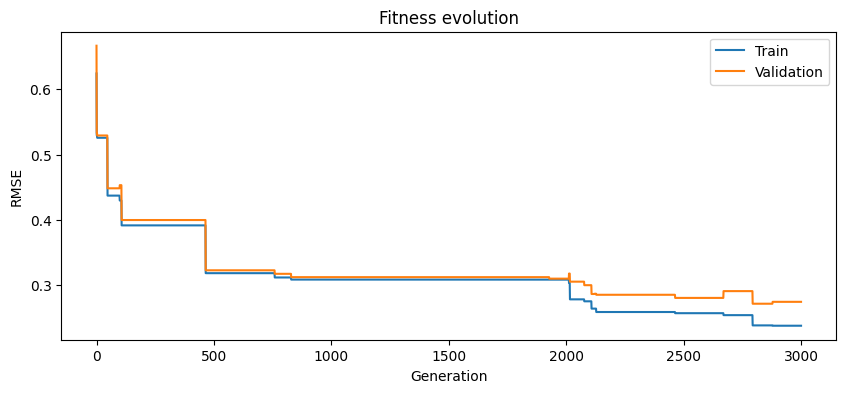

Best solution RMSE fitness: 0.24 train, 0.27 validation.



In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(history_fits, label='Train')
plt.plot(history_val_fits, label='Validation')
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.legend()
plt.show()

print('Best solution RMSE fitness: {:.2f} train, {:.2f} validation.\n'.format(mheuristic.best_sol.fit.item(), mheuristic.best_sol.test_fit.item()))


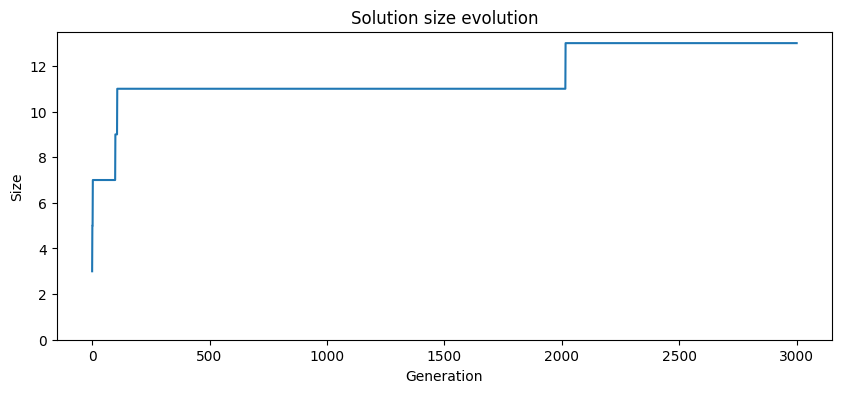

In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(history_sizes)
plt.title('Solution size evolution')
plt.xlabel('Generation')
plt.ylabel('Size')
plt.ylim(bottom=0)
plt.show()


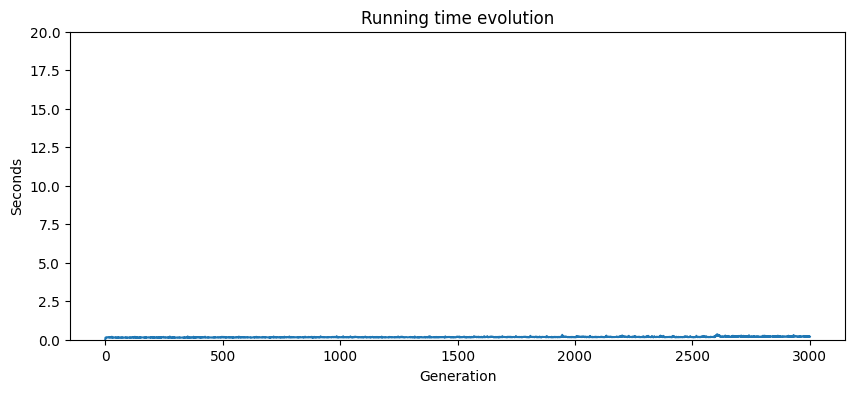

Total time: 8.60 minutes.



In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(history_timing)
plt.title('Running time evolution')
plt.xlabel('Generation')
plt.ylabel('Seconds')
plt.ylim(bottom=0, top=20)
plt.show()

print('Total time: {:.2f} minutes.\n'.format(sum(history_timing)/60.))


In [ ]:
pi_sml._evaluate_sol(mheuristic.best_sol, dl_val)

tensor(0.2744, dtype=torch.float64)

In [ ]:
mheuristic.pop.__repr__()

'<gpolnel.utils.population.PopulationTree object at 0x000001CAE23C2390>'

In [ ]:
mheuristic._evaluate_sol(mheuristic.best_sol.__repr__, dl_val)


AttributeError: 'GeneticAlgorithm' object has no attribute '_evaluate_sol'

In [ ]:
mheuristic.best_sol.printTree(feature_names=feature_names)

add( forage_kg_day, 0.0148 )


In [ ]:
mheuristic.best_sol.get_all_subtrees()[0]

[]

In [ ]:
_execute_tree(mheuristic.best_sol.get_all_subtrees(), dl_val)

IndexError: list index out of range

In [ ]:
mheuristic.__repr__